# Arbitrary state preparation using Model-Free Reinforcement Learning

This notebook showcases an application of the formalism introduced in PhysRevX.12.011059 (https://doi.org/10.1103/PhysRevX.12.011059) on arbitrary qubit state preparation, as depicted in the Appendix D.2b.

The implementation of the quantum environment is done here via Qiskit, using an Estimator primitive (https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials/how-to-getting-started-with-estimator.html) for the execution of parametrized quantum circuits and Pauli expectation sampling.

Author of notebook: Arthur Strauss

Updated on 01/05/2023

In [2]:
import numpy as np
import os
import sys

module_path = os.path.abspath(
    os.path.join(
        "/Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control"
    )
)
if module_path not in sys.path:
    sys.path.append(module_path)
from quantumenvironment import QuantumEnvironment
from helper_functions import select_optimizer, generate_model
from qconfig import QiskitConfig

# Qiskit imports for building RL environment (circuit level)

from qiskit.circuit import ParameterVector, QuantumCircuit
from qiskit.quantum_info import DensityMatrix
from qiskit.opflow import H, I, X, S, CX
from qiskit_ibm_runtime import QiskitRuntimeService, Estimator

# Tensorflow imports for building RL agent and framework
import tensorflow as tf
from tensorflow_probability.python.distributions import MultivariateNormalDiag

# Additional imports
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
from time import sleep

In [3]:
# Ansatz function, could be at pulse level or circuit level


def apply_parametrized_circuit(qc: QuantumCircuit):
    """
    Define ansatz circuit to be played on Quantum Computer. Should be parametrized with Qiskit ParameterVector
    :param qc: Quantum Circuit instance to add the gates on
    :return:
    """
    global n_actions
    params = ParameterVector("theta", n_actions)
    qc.u(2 * np.pi * params[0], 2 * np.pi * params[1], 2 * np.pi * params[2], 0)
    qc.u(2 * np.pi * params[3], 2 * np.pi * params[4], 2 * np.pi * params[5], 1)
    qc.rzx(2 * np.pi * params[6], 0, 1)
    qc.u(2 * np.pi * params[7], 2 * np.pi * params[8], 2 * np.pi * params[9], 1)
    qc.u(2 * np.pi * params[10], 2 * np.pi * params[11], 2 * np.pi * params[12], 2)
    qc.rzx(2 * np.pi * params[13], 1, 2)

# Defining the QuantumEnvironment

Below, we set the RL environment parameters, that is how we describe our quantum system. Below, we can choose to go through the use of Qiskit Runtime, or to speed things up by using the local CPU and a state-vector simulator to get measurement outcomes based on the ansatz circuit defined above. The Environment is defined as a class object called QuantumEnvironment.

In [4]:
qubit_tgt_register = [0, 1, 2]  # Choose which qubits of the QPU you want to address
sampling_Paulis = 50
N_shots = 1  # Number of shots for sampling the quantum computer for each action vector
n_actions = 14  # Choose how many control parameters in pulse/circuit parametrization
time_steps = 1  # Number of time steps within an episode (1 means you do one readout and assign right away the reward)
seed = 3590
estimator_options = {"seed_simulator": seed, "resilience_level": 0}

Choose below which IBM Backend to use. As we are dealing with circuit level implementation, we can look for a backend supporting Qiskit Runtime (could be a cloud simulator, or real backend) or simply set backend to None and rely on the Estimator primitive based on statevector simulation. In either case, we need access to one Estimator primitive to run the algorithm, as the feedback from the measurement outcomes is done by calculating Pauli expectation values.

In [5]:
"""
Real backend initialization:
Run this cell only if intending to use a real backend,
where Qiskit Runtime is enabled
"""
backend_name = "ibm_perth"

# service = QiskitRuntimeService(channel='ibm_quantum')
# runtime_backend = service.get_backend(backend_name)
# estimator_options = {'resilience_level': 0}

In [6]:
"""
If using Qiskit native Estimator primitive
(statevector simulation)
"""
no_backend = None

In [7]:
backend = no_backend

In [8]:
# Define here target state density matrix

# Target state: GHZ state: (|000> + |111>)/sqrt(2)
ket0, ket1 = np.array([[1.0], [0]]), np.array([[0.0], [1.0]])
ket000, ket111 = np.kron(np.kron(ket0, ket0), ket0), np.kron(np.kron(ket1, ket1), ket1)
GHZ_state = (ket000 + ket111) / np.sqrt(2)
GHZ_dm = GHZ_state @ GHZ_state.conj().T
target_state = {"dm": DensityMatrix(GHZ_dm)}
# print("Target state Density matrix:", target_state)

In [9]:
# Wrap all info in one dict Qiskit_setup
Qiskit_setup = QiskitConfig(
    parametrized_circuit=apply_parametrized_circuit,
    backend=backend,
    estimator_options=estimator_options,
)

In [10]:
# Declare QuantumEnvironment variable

q_env = QuantumEnvironment(
    target=target_state,
    abstraction_level="circuit",
    Qiskit_config=Qiskit_setup,
    sampling_Pauli_space=sampling_Paulis,
    n_shots=N_shots,
    c_factor=0.125,
)
print(q_env.target)

{'dm': DensityMatrix([[0.5+0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
                0. +0.j, 0.5+0.j],
               [0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
                0. +0.j, 0. +0.j],
               [0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
                0. +0.j, 0. +0.j],
               [0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
                0. +0.j, 0. +0.j],
               [0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
                0. +0.j, 0. +0.j],
               [0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
                0. +0.j, 0. +0.j],
               [0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
                0. +0.j, 0. +0.j],
               [0.5+0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
                0. +0.j, 0.5+0.j]],
              dims=(2, 2, 2)), 'target_type': 'state', 'Chi': array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  

We now define the Agent, which will be in general a Deep Neural Network.
We start by defining the hyperparameters of the training

In [38]:
# Hyperparameters for the agent
n_epochs = 1500  # Number of epochs
batchsize = 200  # Batch size (iterate over a bunch of actions per policy to estimate expected return)
opti = "Adam"
eta = 0.01  # Learning rate for policy update step
eta_2 = None  # Learning rate for critic (value function) update step

use_PPO = True
epsilon = 0.2  # Parameter for clipping value (PPO)
grad_clip = 0.1
critic_loss_coeff = 0.5
optimizer = select_optimizer(
    lr=eta, optimizer=opti, grad_clip=grad_clip, concurrent_optimization=True, lr2=eta_2
)
sigma_eps = 1e-3  # for numerical stability

In [39]:
# Policy parameters: generate NN that will output mean and variances of the policy

# Policy parameters
N_in = (
    n_qubits + 1
)  # One input for each measured qubit state (0 or 1 input for each neuron)
hidden_units = [100, 100, 100]  # List containing number of units in each hidden layer

network = generate_model((N_in,), hidden_units, n_actions, actor_critic_together=True)
network.summary()
init_msmt = np.zeros(
    (1, N_in)
)  # Here no feedback involved, so measurement sequence is always the same

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 4)]          0                                            
__________________________________________________________________________________________________
hidden_0 (Dense)                (None, 100)          500         input_2[0][0]                    
__________________________________________________________________________________________________
hidden_1 (Dense)                (None, 100)          10100       hidden_0[0][0]                   
__________________________________________________________________________________________________
hidden_2 (Dense)                (None, 100)          10100       hidden_1[0][0]                   
____________________________________________________________________________________________

In [40]:
# Plotting tools
plt.rcParams["figure.dpi"] = 300
plt.rcParams["savefig.dpi"] = 300
avg_return = np.zeros(n_epochs)
fidelities = np.zeros(n_epochs)
visualization_steps = 10
%matplotlib inline

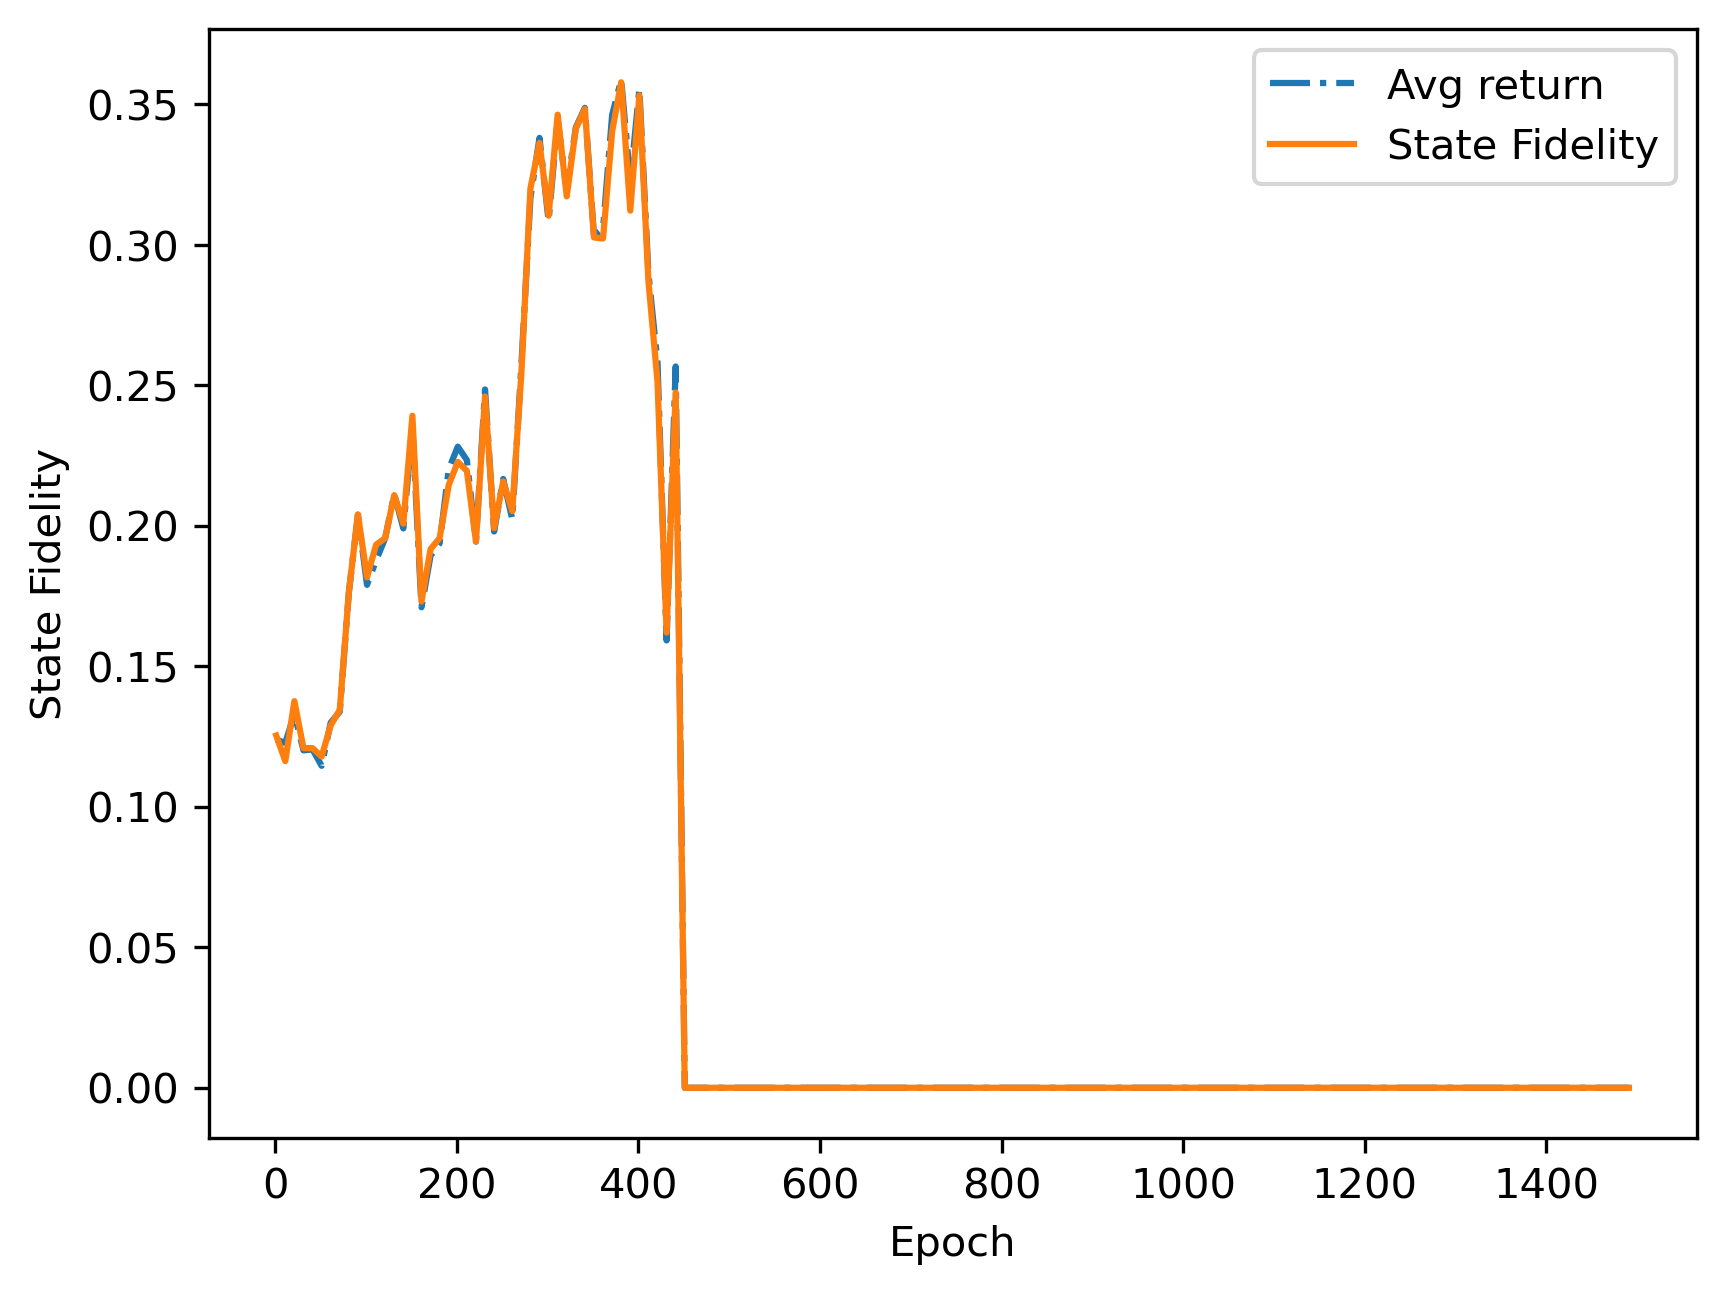

 29%|███████████▊                            | 441/1500 [06:12<15:36,  1.13it/s]

Maximum fidelity reached so far: 0.3949062439983528

 Sending job to Estimator...


 29%|███████████▊                            | 442/1500 [06:13<14:53,  1.18it/s]


 Job done
Fidelity 0.22492370842786708

 Sending job to Estimator...


 30%|███████████▊                            | 443/1500 [06:14<14:22,  1.23it/s]


 Job done
Fidelity 0.25059524941878414

 Sending job to Estimator...


 30%|███████████▊                            | 444/1500 [06:14<13:47,  1.28it/s]


 Job done
Fidelity 0.23852275611861434

 Sending job to Estimator...


 30%|███████████▊                            | 445/1500 [06:15<13:27,  1.31it/s]


 Job done
Fidelity 0.25399331245410756

 Sending job to Estimator...


 30%|███████████▉                            | 446/1500 [06:16<13:14,  1.33it/s]


 Job done
Fidelity 0.26121479071481113

 Sending job to Estimator...


 30%|███████████▉                            | 447/1500 [06:17<13:10,  1.33it/s]


 Job done
Fidelity 0.2468044750227225

 Sending job to Estimator...


 30%|███████████▉                            | 447/1500 [06:18<14:50,  1.18it/s]


KeyboardInterrupt: 

In [41]:
# Training loop 

mu_old = tf.Variable(initial_value=network(init_msmt)[0][0], trainable=False)
sigma_old = tf.Variable(initial_value=network(init_msmt)[1][0], trainable=False)

policy_params_str = 'Policy params:'

for i in tqdm(range(n_epochs)):

    Old_distrib = MultivariateNormalDiag(loc=mu_old, scale_diag=sigma_old,
                                         validate_args=True, allow_nan_stats=False)

    with tf.GradientTape(persistent=True) as tape:

        mu, sigma, b = network(init_msmt, training=True)
        mu = tf.squeeze(mu, axis=0)
        sigma = tf.squeeze(sigma, axis=0)
        b = tf.squeeze(b, axis=0)

        Policy_distrib = MultivariateNormalDiag(loc=mu, scale_diag=sigma,
                                                validate_args=True, allow_nan_stats=False)

        action_vector = tf.stop_gradient(tf.clip_by_value(Policy_distrib.sample(batchsize), -1., 1.))

        reward = q_env.perform_action(action_vector)
        advantage = reward - b

        if use_PPO:
            ratio = Policy_distrib.prob(action_vector) / (tf.stop_gradient(Old_distrib.prob(action_vector)) + 1e-7)
            actor_loss = - tf.reduce_mean(tf.minimum(advantage * ratio,
                                                     advantage * tf.clip_by_value(ratio, 1 - epsilon, 1 + epsilon)))
        else:  # REINFORCE algorithm
            actor_loss = - tf.reduce_mean(advantage * Policy_distrib.log_prob(action_vector))

        critic_loss = tf.reduce_mean(advantage ** 2)
        combined_loss = actor_loss + critic_loss_coeff * critic_loss

    grads = tape.gradient(combined_loss, network.trainable_variables)

    # For PPO, update old parameters to have access to "old" policy
    if use_PPO:
        mu_old.assign(mu)
        sigma_old.assign(sigma)
    avg_return[i] = np.mean(q_env.reward_history, axis =1)[i]
    fidelities[i] = q_env.state_fidelity_history[i]
    print("Fidelity", fidelities[i])
    if i%visualization_steps == 0:
        clear_output(wait=True) # for animation
        fig, ax = plt.subplots()
        ax.plot(np.arange(1, n_epochs, visualization_steps),avg_return[0:-1:visualization_steps], '-.', label='Avg return')
        ax.plot(np.arange(1, n_epochs, visualization_steps),fidelities[0:-1:visualization_steps], label='State Fidelity')
        ax.set_xlabel("Epoch")
        ax.set_ylabel("State Fidelity")
        ax.legend()
        plt.show()
        print("Maximum fidelity reached so far:", np.max(fidelities))
        

    # Apply gradients
    optimizer.apply_gradients(zip(grads, network.trainable_variables))
if isinstance(q_env.estimator, Estimator):
q_env.estimator.session.close()

In [ ]:
print(
    "Maximum fidelity reached:", np.max(fidelities), "at Epoch ", np.argmax(fidelities)
)